In [1]:
# imports

import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.datasets import cifar10
import argparse

In [2]:
# plot func

import matplotlib.pyplot as plt
from keras.models import Sequential
import numpy as np


def plot_training_loss_and_accuracy_keras(epoch_num: int, H: Sequential.fit, savefig_path=None):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, epoch_num), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epoch_num), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epoch_num), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epoch_num), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss / Accuracy")
    plt.legend()
    if not savefig_path:
        plt.show()
    else:
        plt.savefig(savefig_path)

In [3]:
# model

from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K


class MiniVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        if K.image_data_format() == "channels_first":
            input_shape = (depth, height, width)
            chan_dim = 1
        else:
            input_shape = (height, width, depth)
            chan_dim = -1

        # first CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(32, (3, 3), padding="same", input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # second CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(64, (3, 3), padding="same", input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # First and only set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        return model


In [11]:
# learning rate func

def step_decay(epoch):
    initAlpha = 0.01
    factor = 0.5
    drop_every = 5

    # compute learning rate for current epoch
    alpha = initAlpha * (factor ** np.floor((1 + epoch) / drop_every))

    return float(alpha)


In [14]:
# parameters
learning_rate = 0.01  # redundant as learning rate set by step decay
momentum = 0.9
img_w = 32
img_h = 32
img_d = 3
class_num = 10
batch_size = 64
epoch_num = 40

# load data
print("[INFO] loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

# convert labels
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.fit_transform(testY)

label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


[INFO] loading CIFAR-10 data...


In [15]:
# init optimizer and model
callbacks = [LearningRateScheduler(step_decay)]
opt = SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)
model = MiniVGGNet.build(width=img_w, height=img_h, depth=img_d, classes=class_num)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train network
print("[INFO] training network...")
print(f"training set size = {len(trainY)}, validation set size = {len(testY)}")
H = model.fit(trainX, trainY, validation_data=(testX, testY),
              batch_size=batch_size, epochs=epoch_num, callbacks=callbacks, verbose=1)

[INFO] training network...
training set size = 50000, validation set size = 10000
Epoch 1/40
782/782 [==============================] - 11s 12ms/step - loss: 1.6569 - accuracy: 0.4474 - val_loss: 1.4533 - val_accuracy: 0.5074 - lr: 0.0100
Epoch 2/40
782/782 [==============================] - 9s 12ms/step - loss: 1.1553 - accuracy: 0.6023 - val_loss: 0.9734 - val_accuracy: 0.6703 - lr: 0.0100
Epoch 3/40
782/782 [==============================] - 9s 11ms/step - loss: 0.9756 - accuracy: 0.6628 - val_loss: 0.8584 - val_accuracy: 0.7054 - lr: 0.0100
Epoch 4/40
782/782 [==============================] - 9s 12ms/step - loss: 0.8662 - accuracy: 0.7011 - val_loss: 0.7522 - val_accuracy: 0.7352 - lr: 0.0100
Epoch 5/40
782/782 [==============================] - 9s 12ms/step - loss: 0.7330 - accuracy: 0.7414 - val_loss: 0.6724 - val_accuracy: 0.7651 - lr: 0.0050
Epoch 6/40
782/782 [==============================] - 10s 13ms/step - loss: 0.6753 - accuracy: 0.7636 - val_loss: 0.6431 - val_accuracy: 

In [16]:
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=batch_size)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=label_names))

[INFO] evaluating network...
157/157 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

    airplane       0.86      0.83      0.85      1000
  automobile       0.90      0.90      0.90      1000
        bird       0.78      0.73      0.76      1000
         cat       0.70      0.65      0.67      1000
        deer       0.78      0.82      0.80      1000
         dog       0.76      0.76      0.76      1000
        frog       0.83      0.90      0.86      1000
       horse       0.88      0.86      0.87      1000
        ship       0.89      0.91      0.90      1000
       truck       0.86      0.89      0.88      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



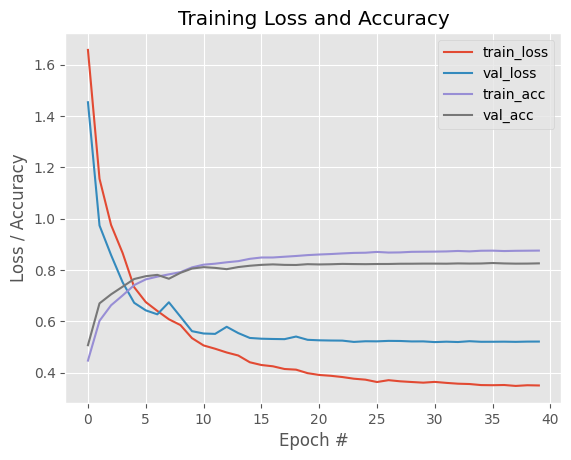

In [17]:
%matplotlib inline
plot_training_loss_and_accuracy_keras(epoch_num=epoch_num, H=H)